In [26]:
%reload_ext autoreload
%autoreload 2

In [27]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config

from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [28]:
bpp = 0.1
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [29]:
logger = setup_file_logger()

In [30]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

In [31]:
learn = None
gc.collect()

370

In [34]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 # 0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True,
                       flip_vert=False,
                       max_rotate=False,
                       max_zoom=0,
                       max_lighting=False,
                       max_warp=False)
batchsize = 32

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(tfms, size=(192, 192), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = None
gc.collect()
learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [35]:
# 2020-09-04try2MSSIM-l2reg-baseline-bpp0p30-8

model_fname =FileNameGenerator.create_fname(f'try2MSSIM-l2reg-baseline-bpp0p{bpp*100:.0f}')
# lrs = [1e-4] *3 + [1e-5] * 4 + [1e-6] *2
# lrs += [1e-4] *20 
lrs  = [1e-4] * 17 + [1e-5]*5
model_fname

'2020-09-04try2MSSIM-l2reg-baseline-bpp0p10'

In [37]:
config.si_loss_weight_alpha = 0
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    
offset = 0
if offset != 0 :
    learn.load(f'{model_fname}-{offset - 1}',with_opt=True)
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    #     if i != 0 :
    #         learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func,use_si=False),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=False)])
    
    learn.save(f'{model_fname}-{i}')
    if i % 3 or i == len(lrs) - 1:
        !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
        !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,815.127258,791.175110,0.112829,08:35


iter 0: bpp = 0.097 imp-mean-var(0.45 0.25) total loss1824.1  l2reg_loss=18.4autoencoder_loss_value=940.0si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.903 imp-mean-var(0.47 0.25) total loss944.8  l2reg_loss=18.3autoencoder_loss_value=127.7si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.766 imp-mean-var(0.37 0.23) total loss795.5  l2reg_loss=18.0autoencoder_loss_value=118.2si_loss=0.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,413.031494,397.802429,0.120758,08:37


iter 0: bpp = 0.077 imp-mean-var(0.38 0.23) total loss816.5  l2reg_loss=18.0autoencoder_loss_value=128.1si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.488 imp-mean-var(0.14 0.11) total loss556.3  l2reg_loss=17.7autoencoder_loss_value=142.5si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.361 imp-mean-var(0.08 0.07) total loss401.3  l2reg_loss=17.5autoencoder_loss_value=128.0si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-1.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-1.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,317.313293,314.038971,0.111007,08:35


iter 0: bpp = 0.036 imp-mean-var(0.09 0.08) total loss413.1  l2reg_loss=17.5autoencoder_loss_value=130.8si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.311 imp-mean-var(0.08 0.07) total loss349.2  l2reg_loss=17.2autoencoder_loss_value=121.6si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.290 imp-mean-var(0.09 0.07) total loss331.6  l2reg_loss=17.0autoencoder_loss_value=118.3si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-2.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-2.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,273.057526,257.909515,0.106202,08:35


iter 0: bpp = 0.029 imp-mean-var(0.08 0.07) total loss329.6  l2reg_loss=17.0autoencoder_loss_value=124.2si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.262 imp-mean-var(0.09 0.07) total loss297.5  l2reg_loss=16.8autoencoder_loss_value=108.0si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.249 imp-mean-var(0.08 0.07) total loss267.4  l2reg_loss=16.6autoencoder_loss_value=107.2si_loss=0.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,367.827789,344.632721,0.103515,08:36


iter 0: bpp = 0.024 imp-mean-var(0.07 0.06) total loss268.8  l2reg_loss=16.6autoencoder_loss_value=113.8si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.905 imp-mean-var(0.49 0.25) total loss979.2  l2reg_loss=16.7autoencoder_loss_value=160.7si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.329 imp-mean-var(0.11 0.10) total loss337.4  l2reg_loss=16.6autoencoder_loss_value=110.1si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-4.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-4.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,1136.847656,1093.147461,0.136726,08:35


iter 0: bpp = 0.035 imp-mean-var(0.13 0.11) total loss369.7  l2reg_loss=16.6autoencoder_loss_value=106.3si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.296 imp-mean-var(0.10 0.08) total loss314.0  l2reg_loss=16.5autoencoder_loss_value=102.3si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 1.049 imp-mean-var(0.09 0.08) total loss1104.2  l2reg_loss=16.5autoencoder_loss_value=141.9si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-5.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-5.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,610.875122,588.299866,0.111974,08:36


iter 0: bpp = 0.104 imp-mean-var(0.09 0.08) total loss1088.2  l2reg_loss=16.5autoencoder_loss_value=130.3si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.769 imp-mean-var(0.07 0.06) total loss811.8  l2reg_loss=16.4autoencoder_loss_value=126.8si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.567 imp-mean-var(0.07 0.06) total loss604.6  l2reg_loss=16.3autoencoder_loss_value=115.7si_loss=0.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,400.689850,386.953552,0.102698,08:36


iter 0: bpp = 0.056 imp-mean-var(0.07 0.06) total loss587.6  l2reg_loss=16.3autoencoder_loss_value=110.7si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.444 imp-mean-var(0.07 0.06) total loss463.7  l2reg_loss=16.2autoencoder_loss_value=107.5si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.374 imp-mean-var(0.07 0.06) total loss390.0  l2reg_loss=16.1autoencoder_loss_value=105.2si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-7.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-7.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,317.390625,306.347992,0.095396,08:25


iter 0: bpp = 0.037 imp-mean-var(0.08 0.07) total loss397.9  l2reg_loss=16.1autoencoder_loss_value=107.7si_loss=0.0feat_loss_value=0.0
iter 500: bpp = 0.331 imp-mean-var(0.08 0.07) total loss342.6  l2reg_loss=16.0autoencoder_loss_value=98.6si_loss=0.0feat_loss_value=0.0
iter 1000: bpp = 0.306 imp-mean-var(0.10 0.08) total loss328.2  l2reg_loss=16.0autoencoder_loss_value=95.7si_loss=0.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-8.pth to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10-8.pth
upload: ./out.log to s3://dsin-us/models/2020-09-04try2MSSIM-l2reg-baseline-bpp0p10.log


epoch,train_loss,valid_loss,MS_SSIM,time


KeyboardInterrupt: 

In [38]:
lrs  = [1e-4] * 9 + [1e-5]*5
offset = 9
if offset != 0 :
    learn.load(f'{model_fname}-{offset - 1}',with_opt=False)
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    #     if i != 0 :
    #         learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func,use_si=False),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=False)])
    
    learn.save(f'{model_fname}-{i}')
    if i % 3 or i == len(lrs) - 1:
        !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
        !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.029 imp-mean-var(0.07 0.06) total loss306.1  l2reg_loss=16.0autoencoder_loss_value=94.3si_loss=0.0feat_loss_value=0.0


KeyboardInterrupt: 

In [99]:
for c in learn.model.enc.children():
    print(c)


Sequential(
  (0): ChangeImageStatsToKitti(
    (sigmoid): Sigmoid()
  )
  (1): Conv2dReluBatch2d(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
      (1): ReLU()
      (2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Conv2dReluBatch2d(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
      (1): ReLU()
      (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
Sequential(
  (0): UberResBlock(
    (model): Sequential(
      (0): ResBlock(
        (model): Sequential(
          (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
          (1): ReLU()
          (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(128, 128, kernel_size=[3, 3

In [95]:
t=[]
for p in learn.model.parameters():
    t.append(torch.histc(p,min=-0.2,max =1).detach().cpu().float().log1p())
#     break
t = torch.stack(t).permute(1,0)
t.shape

torch.Size([100, 221])

(-0.5, 220.5, -0.5, 99.5)

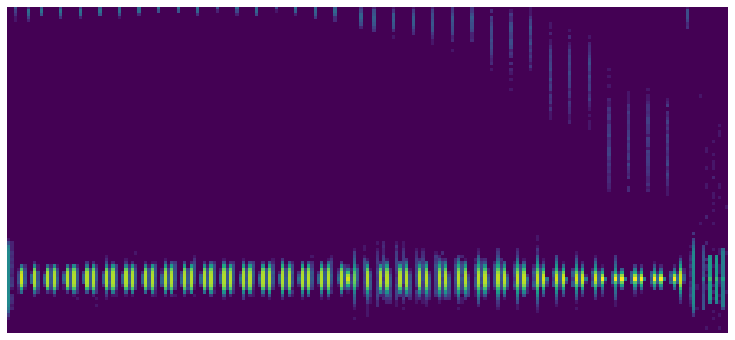

In [96]:
fig, ax = plt.subplots(figsize=(15,6))
ax.imshow(t, origin='lower')
ax.axis('off')


In [79]:
len(t)


1

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6931, 3.2958, 5.3230,
        6.0113, 6.1137, 6.0234, 6.0403, 6.0615, 6.0868, 5.9764, 6.0355, 6.0776,
        6.0638, 5.6904, 3.8067, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

(array([   0.,    0.,    0.,    0., 2348., 2452.,    0.,    0.,    0.,    0.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

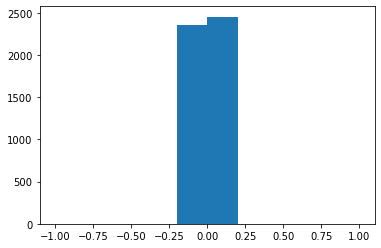

In [59]:
plt.hist(np.linspace(-1,1,100), weights =t.cpu().detach().numpy())

In [ ]:
learn.save(f'{model_fname}-{i}')

!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


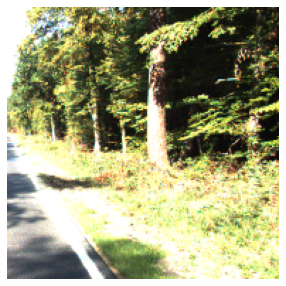

In [24]:
mt = learn.model.my_tuple[-3][0,...].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(5,5))
# # print(mn)

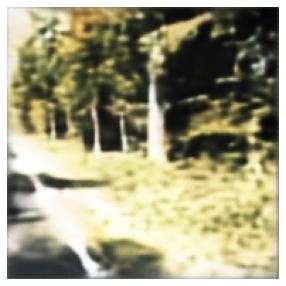

In [25]:
mt = learn.model.my_tuple[3][0,...].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(5,5))